In [96]:
from private.db.tianrun.spot.fdw.new_energy_actual_power import market_hourly_actual_power, market_name_dict
from private.db.tencnet.openmeteo.china_openmeteo_forecast3 import ProvinceForecastData

# from finance_utils.electrical2.spot.probabilistic.forecast.torch.transformer.vanilla2 import (
#     VanillaTransformer, vanilla_transformer_tester, vanilla_transformer_trainer, vanilla_transformer_trainer2)

from finance_utils.electrical2.spot.probabilistic.forecast.torch.transformer.vanilla_encoder import (
    VanillaTransformerEncoder, vanilla_transformer_tester, vanilla_transformer_trainer, vanilla_transformer_trainer2)

from private.db.tencnet.openmeteo.china_openmeteo_forecast3 import cma_new_energy_args, ecmwf_new_energy_args
from finance_utils.electrical2.spot.probabilistic.forecast.datasource.pfd_and_new_energy import torch_data_set as torch_data_set1
from finance_utils.electrical2.spot.probabilistic.forecast.datasource.pfd_and_new_energy2 import torch_data_set as torch_data_set2
from finance_utils.electrical2.spot.probabilistic.forecast.torch.normalization.basic import MinMax,ZScore,RobustScaler
import numpy
import pickle
import tqdm
from easy_datetime.timestamp import TimeStamp

import torch
from matplotlib import pyplot as plt
# from data_utils.serial_utils.series_trans_utils import MinMax, ZScore, RobustScaler, KmeansCluster

import os

import torch
from torch import nn

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor

In [97]:
root = r"E:\code\github\private\private\db\tencnet\openmeteo\data"
# with open(f"{root}\\test_ecmwf.pfd", "rb") as f:
with open(f"{root}\\test_cma.pfd", "rb") as f:
    pfd:ProvinceForecastData = pickle.loads(f.read())
    
with open(f"{root}\\china_cma.pfd", "rb") as f:
    pfd2:ProvinceForecastData = pickle.loads(f.read())
    
print(pfd.stdt)
print(pfd.eddt)

2024-10-01 00:00:00
2024-10-31 23:59:59


In [98]:
x_norml_method = ZScore
y_norml_method = ZScore
fore_start = TimeStamp("2024-10-1")
fore_days = 8
fore_end = fore_start + ["day", fore_days]
x,x_hat,y,y_hat, yp = torch_data_set2(pfd, x_norml_method, y_norml_method, fore_start, fore_end, 
                                     ["cma", "evening", 1, 1],
                                     delete_column=[], province_name="PHBSX",dims=cma_new_energy_args)

x2,x_hat2,_,_,_ = torch_data_set2(pfd2, x_norml_method, y_norml_method, fore_start, fore_end, 
                                     ["cma", "evening", 1, 1],
                                     delete_column=[], province_name="PHBSX",dims=cma_new_energy_args)


# x,x_hat,y,y_hat, yp = torch_data_set2(pfd, x_norml_method, y_norml_method, fore_start, fore_end, 
#                                      ["ecmwf", "evening", 1, 1],
#                                      delete_column=[], province_name="PHBSX",dims=ecmwf_new_energy_args)


for p in (x,x_hat,y,y_hat, yp):
    print(f"{p.shape}")
    
print(fore_start)
print(fore_end)

100%|██████████| 4507/4507 [00:00<00:00, 204676.62it/s]


torch.Size([192, 1132])
torch.Size([216, 1132])
torch.Size([192])
torch.Size([216])
(4,)
2024-10-01 00:00:00
2024-10-09 00:00:00


In [99]:
x = torch.column_stack((x[24:], x2[24:], y[:len(y)-24]))
x_hat = torch.column_stack((x_hat[24:], x_hat2[24:], y))
# x = x[24:]
# x_hat = x_hat[24:]
# x = torch.column_stack((x[24:][:,0], y[:len(y)-24])) 
# x_hat = torch.column_stack((x_hat[24:][:,0], y))

In [100]:
y = y[24:]
y_hat = y_hat[24:]

In [101]:
for p in (x,x_hat,y,y_hat, yp):
    print(f"{p.shape}")

torch.Size([168, 5640])
torch.Size([192, 5640])
torch.Size([168])
torch.Size([192])
(4,)


In [102]:
input_size = x.shape[1]
d_model = 256
dim_feedforward = 1024
nhead = 8
output_size = 1
# num_layers = 4
num_layers = 8
# batch_size = fore_days * 4
batch_size = (fore_days - 1) * 2
# batch_size = 6
lr = 1e-3
use_y_tgt = False

model = VanillaTransformerEncoder(
    input_size=input_size,
    output_size=output_size,
    num_layers=num_layers,
    d_model=d_model,
    nhead=nhead,
    dim_feedforward=dim_feedforward,
    dropout=0.1
)

# model = VanillaTransformer(
#     input_size=input_size,
#     output_size=output_size,
#     num_encoder_layers=num_layers,
#     num_decoder_layers=num_layers,
#     d_model=d_model,
#     nhead=nhead,
#     dim_feedforward=dim_feedforward,
#     dropout=0.1
# )

print(model.cuda_device)
print(batch_size)

cpu
14


C:\Users\sangsiyuan\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [103]:
trained_model = vanilla_transformer_trainer2(model, x, y, batch_size, 100, lr=lr, loser=nn.L1Loss, shuffle=True)
# trained_model = vanilla_transformer_trainer2(model, x, y, batch_size, 100, lr=lr, L2=1e-5, loser=nn.L1Loss, shuffle=True, use_y_tgt=use_y_tgt)
# trained_model = vanilla_transformer_trainer(model, x, y, batch_size, 200, lr=lr, L2=1e-5, loser=nn.L1Loss)

100%|██████████| 100/100 [00:12<00:00,  7.76it/s]


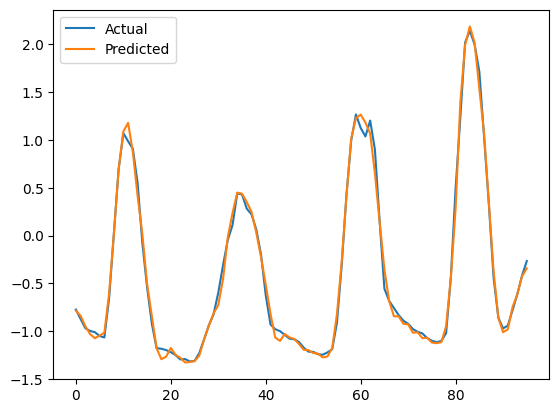

In [104]:
p_train = vanilla_transformer_tester(trained_model, x, batch_size)
# p_train = vanilla_transformer_tester(trained_model, x, batch_size,use_y_tgt=use_y_tgt, train_y_tensor=y)

plt.plot(y.reshape(-1)[len(y) - 24*4:], label='Actual')
plt.plot(p_train.cpu().view(-1)[len(y) - 24*4:], label='Predicted')
# plt.plot(p[:,1], label='Predicted')
plt.legend()
plt.show()

In [109]:
rfr = SVR()
rfr.fit(x.reshape(-1,input_size).numpy(),y.reshape(-1).numpy())
rfr_p = rfr.predict(x_hat.reshape(-1, input_size).numpy())
hn = [6159.8381500000005, 6535.6551174999995, 6799.7823025, 6915.24396, 6990.8038575, 7078.117325, 7296.065965, 8905.946225, 11763.76468, 15103.342045, 18058.1987675, 20035.2812775, 21573.993430000002, 22272.393465, 21871.654837500002, 19932.5611275, 16828.811765000002, 13501.439042500002, 11142.191534999998, 10271.407855, 9530.095075000001, 8844.051477500001, 8145.40068, 7514.1155675]

tensor(-0.5706)
tensor(-0.2422)


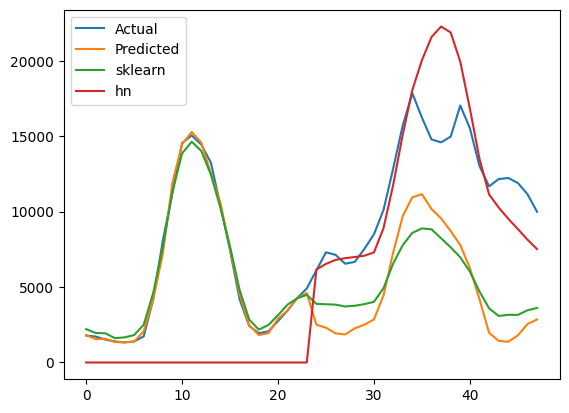

In [111]:
p_test = vanilla_transformer_tester(trained_model, x_hat[24:], batch_size)
# p_test = vanilla_transformer_tester(trained_model, x_hat[24:], batch_size, use_y_tgt=use_y_tgt, train_y_tensor=y)

p_test_view = p_test.view(-1)
d = p_test_view[-24:][0] - y.view(-1)[-1]
svr_d = rfr_p[-24:][0] - y.view(-1)[-1]


print(d)
print(svr_d)

plt.plot(y_hat[24:].reshape(-1)[-24*2:], label='Actual')
# plt.plot(y_norml_method.invert(p_test.view(-1) - d, yp)[-24*2:], label='Predicted_D')
plt.plot(y_norml_method.invert(p_test.view(-1), yp)[-24*2:], label='Predicted')
# plt.plot(y_norml_method.invert(rfr_p - svr_d.numpy(), yp)[-24*2:], label='sklearn_D')
plt.plot(y_norml_method.invert(rfr_p, yp)[-24*2:], label='sklearn')
plt.plot([0]*24 + hn, label='hn')
# plt.plot(p[:,1], label='Predicted')
plt.legend()
plt.show()

100%|██████████| 24/24 [00:01<00:00, 20.44it/s]


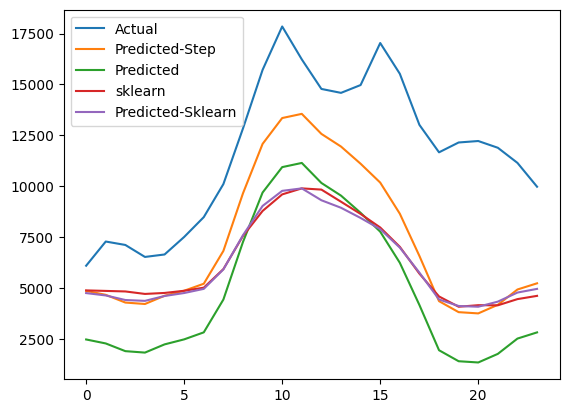

In [107]:
step_by_step_model_p = []
for i in tqdm.trange(1,25):
    x_hat_step = x_hat[i:i+len(x)]
    y_hat_step = y_hat[i:i+len(x)]
    # p_step_test = vanilla_transformer_tester(trained_model, x_hat_step, batch_size, use_y_tgt=use_y_tgt, train_y_tensor=y)
    p_step_test = vanilla_transformer_tester(trained_model, x_hat_step, batch_size)
    step_by_step_model_p.append(p_step_test.view(-1)[-1]) 
# un_norm_step_by_step_model_p = y_norml_method.invert(step_by_step_model_p, yp)
    
step_by_step_model_p = numpy.array(step_by_step_model_p)

plt.plot(y_hat[24:].reshape(-1)[-24:], label='Actual')
plt.plot(y_norml_method.invert(step_by_step_model_p - d.numpy(), yp), label='Predicted-Step')
plt.plot(y_norml_method.invert(p_test.view(-1), yp)[-24:], label='Predicted')

svr = y_norml_method.invert(rfr_p -svr_d.numpy(), yp)[-24:]

plt.plot(svr, label='sklearn')

plt.plot(MinMax.f(p_test.view(-1)[-24:], b=max(svr), a= min(svr)), label='Predicted-Sklearn')

# plt.plot(p[:,1], label='Predicted')
plt.legend()
plt.show()

In [108]:
print([i[1] for i in pfd.cma_grouped_menu])

TypeError: 'float' object is not subscriptable